In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import concurrent.futures
import os

import PIL
import random

In [2]:
# count = 0
# for file in os.listdir("./kagglecatsanddogs_5340/PetImages/Dog"):
#     try:
#         img_bytes = tf.io.read_file("./kagglecatsanddogs_5340/PetImages/Dog/" + file)
#         decoded_img = tf.io.decode_image(img_bytes)
#     except tf.errors.InvalidArgumentError as e:
#         count += 1
#         #os.remove("./kagglecatsanddogs_5340/PetImages/Dog/" + file)

# print(count)

In [3]:
# import shutil

#reverse
# for file in os.listdir("./Train/Dog"):
#     destination = os.path.abspath("./kagglecatsanddogs_5340/PetImages/Dog/")
#     old = os.path.abspath("./Train/Dog/" + file)
#     shutil.move(old, destination)

# dog_files = random.choices(os.listdir("./kagglecatsanddogs_5340/PetImages/Dog"), k=3000)
# for file in dog_files:
#     if len(os.listdir("./Train/Dog")) == 2500:
#         break
#     old = os.path.abspath("./kagglecatsanddogs_5340/PetImages/Dog/" + file)
#     destination = os.path.abspath("./Train/Dog/")
#     try:
#         shutil.move(old, destination)
#     except:
#         continue

# print(len(os.listdir("./Train/Dog")))

In [4]:
img_height, img_width = (200, 200)
batch_size = 32

data_dir = "./kagglecatsanddogs_5340/PetImages"
test_dir = "./Train"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 19981 files belonging to 2 classes.
Using 15985 files for training.
Found 19981 files belonging to 2 classes.
Using 3996 files for validation.
Found 5012 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Cat', 'Dog']


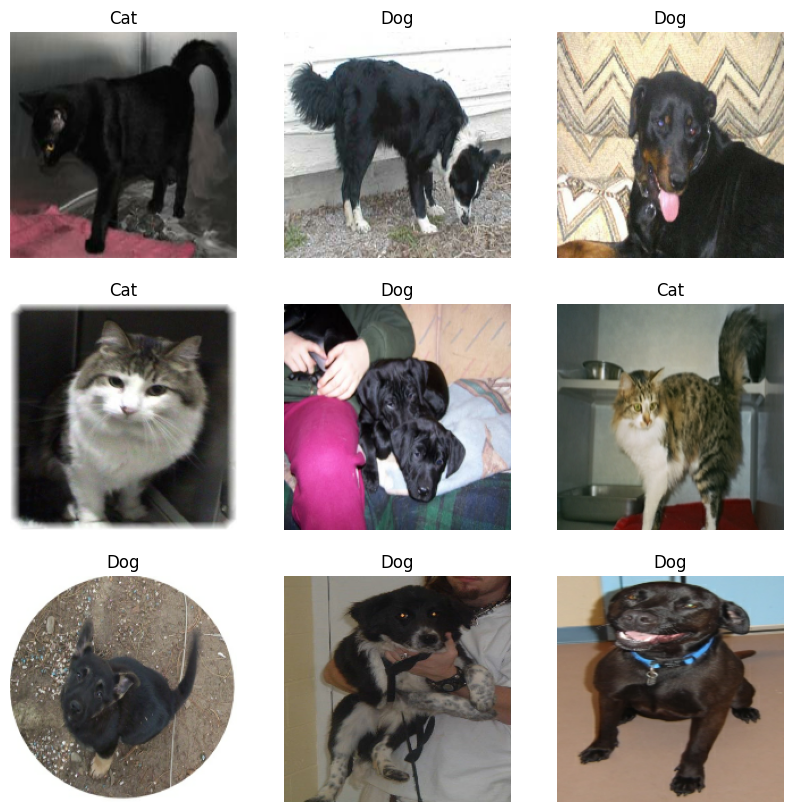

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# num_classes = len(class_names)

# model = models.Sequential()
# model.add(layers.Rescaling(1./127.5, offset=-1))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(num_classes))

In [9]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3),
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)

In [10]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [11]:
num_classes = len(class_names)

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,074,370
Trainable params: 2,359,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [13]:
callbacks_list = [PlotLearning()]

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']           
)

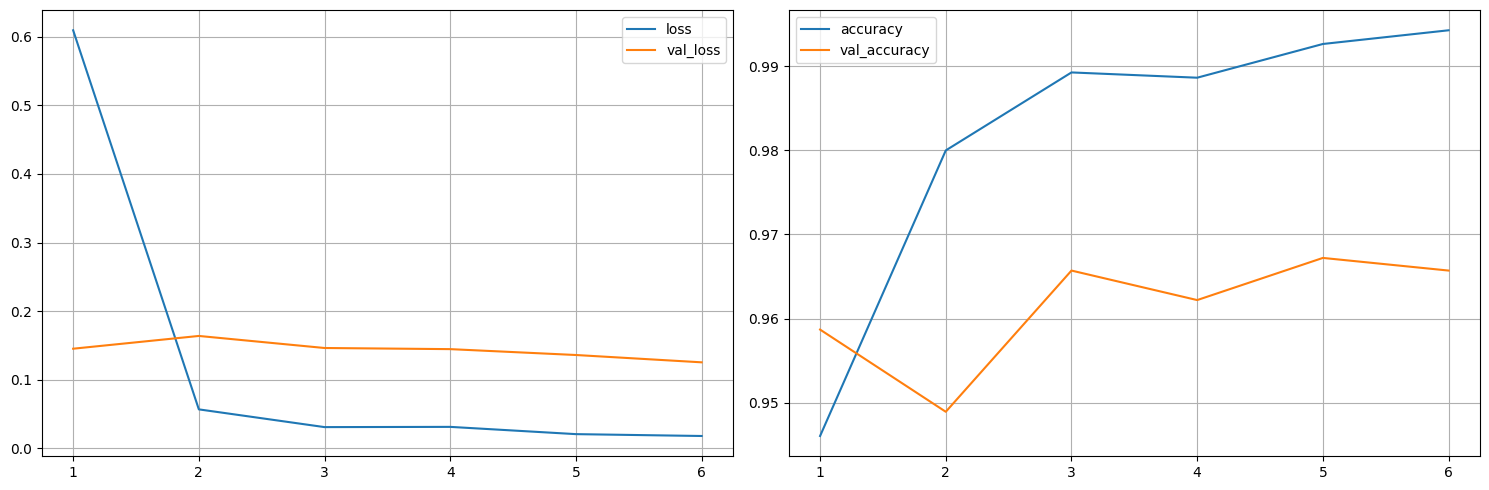

500/500 [==============================] - 739s 1s/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.1252 - val_accuracy: 0.9657


In [14]:
history = model.fit(train_ds, epochs=6, validation_data=val_ds, callbacks=callbacks_list)

In [15]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(test_acc)

157/157 [==============================] - 191s 1s/step - loss: 0.1093 - accuracy: 0.9707
0.9706704020500183


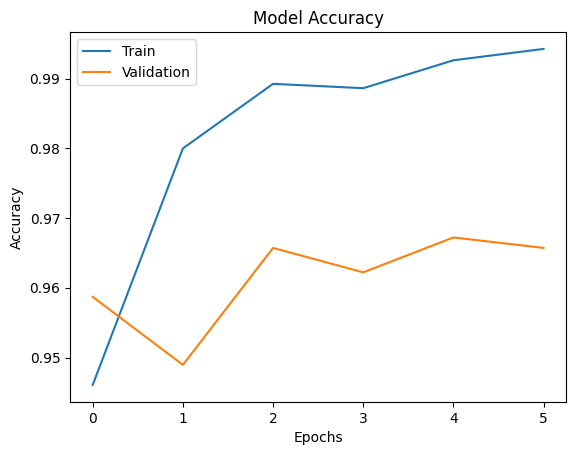

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

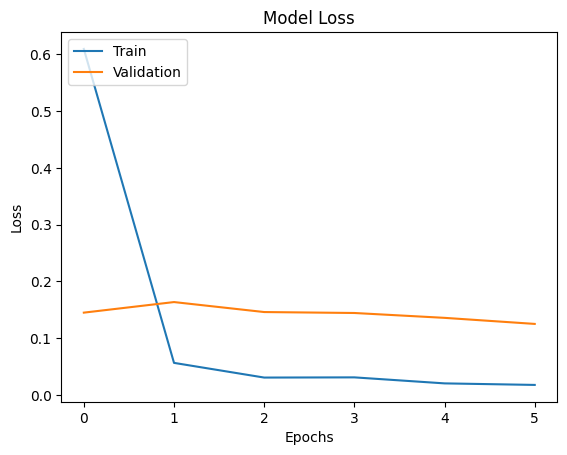

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
model.save("./Models/VGG_Model.keras")

[[-14.310487  17.344942]]
[[-2.1657672 -3.1516235]]
[[ 5.0879626 18.058975 ]]
[[-17.375786  24.534975]]
[[ 3.8582044 89.87762  ]]
[[ 2.9011457 26.489458 ]]
[[-19.784391 -28.478674]]
[[-5.205203  -2.3473308]]
[[-15.266699  -6.840713]]


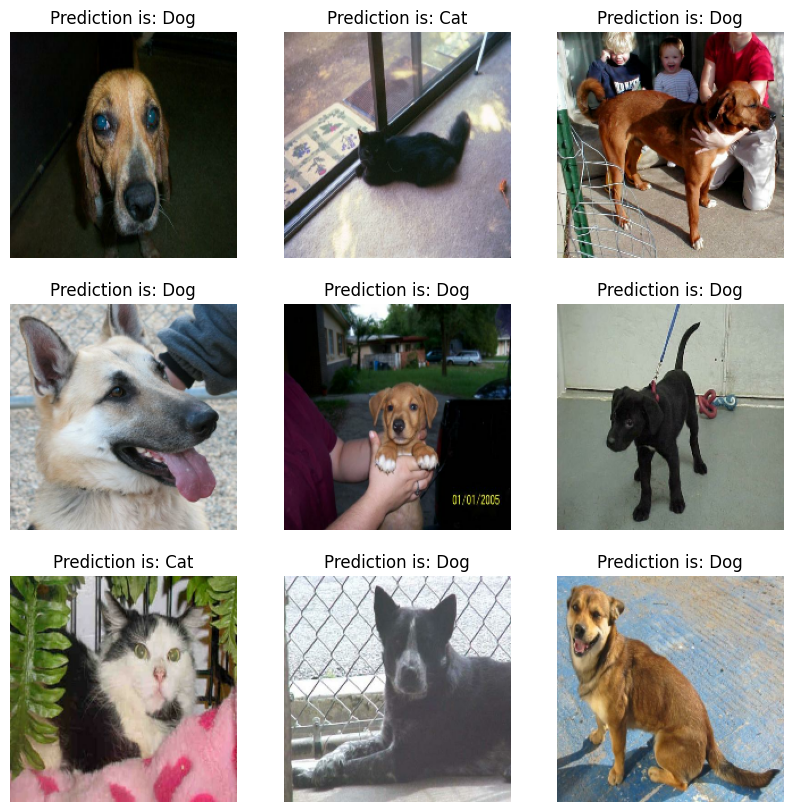

In [61]:
plt.figure(figsize=(10, 10))
shuffled_ds = test_ds.shuffle(buffer_size=len(test_ds))
for images, labels in shuffled_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image_arr = images[i].numpy().astype("uint8")
        
        plt.imshow(image_arr)
        
        image_arr = np.reshape(image_arr, [1, 200, 200, 3])
        prediction = model.predict(image_arr, verbose=0)
        
        print(prediction)
        
        plt.title(f"Prediction is: {class_names[np.argmax(prediction)]}")
        plt.axis("off")